In [1]:
import os
import numpy as np
import cupy as cp

In [16]:
#加载 CIFAR-10 数据集
import pickle
import urllib.request
import tarfile

def download_and_extract_cifar10(data_dir='cifar-10-batches-py'):
    if not os.path.exists(data_dir):
        url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
        filename = url.split('/')[-1]
        urllib.request.urlretrieve(url, filename)
        with tarfile.open(filename, 'r:gz') as tar:
            tar.extractall()
        print("CIFAR-10 downloaded and extracted.")
    else:
        print("CIFAR-10 already exists.")

def load_cifar_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='bytes')
        X = datadict[b'data'].reshape(10000, 3, 32, 32).astype("float32") / 255.0
        Y = cp.array(datadict[b'labels'])
        return X, Y

def load_cifar10(data_dir='cifar-10-batches-py'):
    xs, ys = [], []
    for i in range(1, 6):
        filename = os.path.join(data_dir, f'data_batch_{i}')
        X, Y = load_cifar_batch(filename)
        xs.append(cp.asarray(X))  # 转换为 CuPy 数组
        ys.append(cp.asarray(Y))
    X_train = cp.concatenate(xs)
    Y_train = cp.concatenate(ys)
    X_test, Y_test = load_cifar_batch(os.path.join(data_dir, 'test_batch'))
    X_test = cp.asarray(X_test)
    Y_test = cp.asarray(Y_test)
    return X_train, Y_train, X_test, Y_test

# onehot编码
def one_hot(Y, num_classes=10):
    out = cp.zeros((Y.shape[0], num_classes), dtype=cp.float32)
    out[cp.arange(Y.shape[0]), Y] = 1
    return out


# 下载并加载数据
download_and_extract_cifar10()
X_train, Y_train, X_test, Y_test = load_cifar10()
Y_train = one_hot(Y_train)
Y_test = one_hot(Y_test)


CIFAR-10 already exists.


In [17]:
class ConvLayer:
    def __init__(self, in_ch, out_ch, ksize=3, pad=1, stride=1):
        self.in_ch, self.out_ch = in_ch, out_ch
        self.ksize, self.pad, self.stride = ksize, pad, stride

        # He初始化！！
        scale = cp.sqrt(2.0 / (in_ch * ksize * ksize))
        self.kernel = cp.random.randn(out_ch, in_ch, ksize, ksize) * scale
        self.bias = cp.zeros(out_ch, dtype=cp.float32)

         # 动量优化相关变量
        self.v_kernel = cp.zeros_like(self.kernel)
        self.v_bias = cp.zeros_like(self.bias)

    def forward(self, x):
        self.x = x
        N, C, H, W = x.shape
        k, p, s = self.ksize, self.pad, self.stride

        # 填充输入
        x_padded = cp.pad(x, ((0,0), (0,0), (p,p), (p,p)))
        kh, kw = k, k
        out_h = (H + 2*p - kh) // s + 1
        out_w = (W + 2*p - kw) // s + 1

        patches = cp.lib.stride_tricks.sliding_window_view(x_padded, (kh, kw), axis=(2,3))
        patches = patches[:, :, ::s, ::s, :, :]
        patches = patches.transpose(0, 2, 3, 1, 4, 5).reshape(N*out_h*out_w, -1)
        self.patches, self.shape = patches, (N, out_h, out_w) # 保存用于反向传播

        weight_mat = self.kernel.reshape(self.out_ch, -1)
        out = patches @ weight_mat.T + self.bias[None, :]
        return out.reshape(N, out_h, out_w, self.out_ch).transpose(0, 3, 1, 2)

    def backward(self, dout, lr=0.01, momentum=0.9):
        N, C_out, H_out, W_out = dout.shape
        dout_flat = dout.transpose(0, 2, 3, 1).reshape(-1, C_out)

        dw = dout_flat.T @ self.patches
        db = cp.sum(dout_flat, axis=0)F

        W_flat = self.kernel.reshape(C_out, -1)
        dx_col = dout_flat @ W_flat

        # 将梯度重新排列为图像块形式
        dx_col = dx_col.reshape(N, H_out, W_out, self.in_ch, self.ksize, self.ksize).transpose(0,3,4,5,1,2)
        dx = cp.zeros((N, self.in_ch, H_out * self.stride + 2*self.pad, W_out * self.stride + 2*self.pad), dtype=cp.float32)

        for i in range(self.ksize):
            for j in range(self.ksize):
                dx[:, :, i:i+H_out*self.stride:self.stride, j:j+W_out*self.stride:self.stride] += dx_col[:, :, i, j, :, :]

        if self.pad > 0:
            dx = dx[:, :, self.pad:-self.pad, self.pad:-self.pad]

        self.v_kernel = momentum * self.v_kernel - lr * dw.reshape(self.kernel.shape)
        self.v_bias = momentum * self.v_bias - lr * db
        self.kernel += self.v_kernel
        self.bias += self.v_bias

        return dx


In [19]:
class LinearLayer:
    # He初始化！！保持前向传播的方差稳定
    def __init__(self, in_dim, out_dim):
        scale = cp.sqrt(2.0 / in_dim)
        self.W = cp.random.randn(in_dim, out_dim) * scale
        self.b = cp.zeros((1, out_dim))
        self.v_W = cp.zeros_like(self.W)
        self.v_b = cp.zeros_like(self.b)

    def forward(self, x):
        self.x = x
        return cp.dot(x, self.W) + self.b

    def backward(self, dout, lr=0.01, momentum=0.9):
        dx = cp.dot(dout, self.W.T)
        dW = cp.dot(self.x.T, dout)
        db = cp.sum(dout, axis=0, keepdims=True)
        
        # Momentum 更新
        self.v_W = momentum * self.v_W - lr * dW
        self.v_b = momentum * self.v_b - lr * db
        self.W += self.v_W
        self.b += self.v_b
        return dx


In [20]:
class FlattenLayer:
    # 将多维输入展平为二维矩阵
    def forward(self, x):
        self.shape = x.shape
        return x.reshape(x.shape[0], -1)

    # 将梯度还原为原始形状
    def backward(self, dout):
        return dout.reshape(self.shape)

class Relu:
    def forward(self, x):
        self.mask = x > 0
        return x * self.mask

    # ReLU梯度计算
    def backward(self, dout):
        return dout * self.mask

In [21]:
class BatchNorm:
    def __init__(self, channels, momentum=0.9, eps=1e-5):
        self.gamma = cp.ones((1, channels, 1, 1))
        self.beta = cp.zeros((1, channels, 1, 1))
        self.momentum = momentum
        self.eps = eps
        self.running_mean = cp.zeros((1, channels, 1, 1))
        self.running_var = cp.ones((1, channels, 1, 1))

    def forward(self, x, train=True):
        self.x = x
        if train:
            self.mean = cp.mean(x, axis=(0, 2, 3), keepdims=True)
            self.var = cp.var(x, axis=(0, 2, 3), keepdims=True)
            self.std = cp.sqrt(self.var + self.eps)
            self.x_norm = (x - self.mean) / self.std  # 保存本 batch 的归一化值
            self.running_mean = self.momentum * self.running_mean + (1 - self.momentum) * self.mean
            self.running_var = self.momentum * self.running_var + (1 - self.momentum) * self.var
        else:
            self.x_norm = (x - self.running_mean) / cp.sqrt(self.running_var + self.eps)

        return self.gamma * self.x_norm + self.beta

    def backward(self, dout, lr=0.01):
        N, C, H, W = dout.shape
        m = N * H * W

        # 保证 x, x_norm 和 dout 维度匹配
        dgamma = cp.sum(dout * self.x_norm, axis=(0, 2, 3), keepdims=True)
        dbeta = cp.sum(dout, axis=(0, 2, 3), keepdims=True)
        dx_norm = dout * self.gamma

        dvar = cp.sum(dx_norm * (self.x - self.mean) * -0.5 * (self.std**-3), axis=(0, 2, 3), keepdims=True)
        dmean = cp.sum(-dx_norm / self.std, axis=(0, 2, 3), keepdims=True) + \
                dvar * cp.sum(-2 * (self.x - self.mean), axis=(0, 2, 3), keepdims=True) / m
        dx = dx_norm / self.std + dvar * 2 * (self.x - self.mean) / m + dmean / m

        self.gamma -= lr * dgamma
        self.beta -= lr * dbeta
        return dx


In [22]:
# 验证集性能不再提升时提前终止训练
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, test_loss):
        if test_loss < self.best_loss:
            self.best_loss = test_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [23]:
class SoftmaxLoss:
    # 计算Softmax损失和准确率
    def forward(self, x, y):
 
        # 数值稳定性处理
        x = x - cp.max(x, axis=1, keepdims=True)

        # 计算Softmax概率
        exp = cp.exp(x)
        self.probs = exp / cp.sum(exp, axis=1, keepdims=True)
        self.y = y
        self.use_one_hot = (y.ndim == 2)

        # 算交叉熵损失
        if self.use_one_hot:
            loss = -cp.sum(y * cp.log(self.probs + 1e-8)) / y.shape[0]
            acc = cp.mean(cp.argmax(self.probs, axis=1) == cp.argmax(y, axis=1))
        else:
            N = x.shape[0]
            loss = -cp.mean(cp.log(self.probs[cp.arange(N), y] + 1e-8))
            acc = cp.mean(cp.argmax(self.probs, axis=1) == y)

        return loss, acc

    # 计算损失对输入x的梯度
    def backward(self):
        N = self.y.shape[0]
        if self.use_one_hot:
            dx = (self.probs - self.y) / N
        else:
            dx = self.probs.copy()
            dx[cp.arange(N), self.y.flatten()] -= 1
            dx /= N
        return dx


In [24]:
class IdentityLayer:
    def forward(self, x):
        return x
    def backward(self, dout, *args, **kwargs):
        return dout
    @property
    def l2_loss(self):
        return 0.0

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import math

# mixup function
def mixup_data(x, y, alpha=0.4):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.shape[0]
    index = cp.random.permutation(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index]
    mixed_y = lam * y + (1 - lam) * y[index]
    return mixed_x, mixed_y

# Cutout augmentation
def cutout(x, cutout_size=8): 
    B, C, H, W = x.shape
    for i in range(B):
        cx = np.random.randint(W)
        cy = np.random.randint(H)
        x1 = np.clip(cx - cutout_size // 2, 0, W)
        x2 = np.clip(cx + cutout_size // 2, 0, W)
        y1 = np.clip(cy - cutout_size // 2, 0, H)
        y2 = np.clip(cy + cutout_size // 2, 0, H)
        x[i, :, y1:y2, x1:x2] = 0  # 置为零
    return x




def train(model, X, Y, X_test=None, Y_test=None, epochs=10, batch=64, lr=0.01, reg_lambda=1e-4):
    stopper = EarlyStopping(patience=5)
    best_val_acc = 0
    best_weights = None

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(epochs):
        # warmup + cosine annealing
        warmup_epochs = 5
        if epoch < warmup_epochs:
            current_lr = lr * (epoch + 1) / warmup_epochs
        else:
            cosine_epoch = epoch - warmup_epochs
            total_cosine_epochs = epochs - warmup_epochs
            current_lr = lr * 0.5 * (1 + math.cos(math.pi * cosine_epoch / total_cosine_epochs))


        idx = cp.random.permutation(X.shape[0])
        X, Y = X[idx], Y[idx]
        total_loss, correct = 0.0, 0

        print(f"\nEpoch {epoch+1}/{epochs}")
        for i in range(0, X.shape[0], batch):
            xb = X[i:i+batch]
            yb = Y[i:i+batch]

            #  apply mixup
            xb, yb = mixup_data(xb, yb, alpha=0.6)
            #  apply cutout
            xb = cutout(xb, cutout_size=8)


            loss, acc = model.forward(xb, yb)
            reg_loss = model.l2_loss()
            loss_with_reg = loss + reg_lambda * reg_loss / X.shape[0]
            total_loss += loss_with_reg * xb.shape[0]

            model.backward(yb, lr=current_lr)
            pred = model.predict(xb)
            correct += cp.sum(pred == cp.argmax(yb, axis=1))

            bar_len = 50
            done = int((i + batch) / X.shape[0] * bar_len)
            bar = '=' * done + ' ' * (bar_len - done)
            print(f"\r[{bar}] {round((i + batch) / X.shape[0] * 100):3d}% ", end='', flush=True)

        avg_loss = total_loss / X.shape[0]
        train_acc = correct / X.shape[0]
        train_loss_history.append(avg_loss)
        train_acc_history.append(float(train_acc))

        if X_test is None or Y_test is None:
            print(f"\nTrain Loss: {avg_loss:.4f} | Train Accuracy: {train_acc:.4f}")
        else:
            test_loss, test_acc = test(model, X_test, Y_test)
            val_loss_history.append(test_loss)
            val_acc_history.append(test_acc)

            if test_acc > best_val_acc:
                best_val_acc = test_acc
                best_weights = {
                    k: {"W": v.W.copy(), "b": v.b.copy()}
                    for k, v in model.__dict__.items()
                    if hasattr(v, "W") and hasattr(v, "b")
                }
                save_params(model, "/kaggle/working/current_best.npz")

            stopper(test_loss)
            print(f"\nEpoch {epoch+1}: Loss {avg_loss:.4f}, Accuracy {train_acc:.4f} | "
                  f"Test Loss {test_loss:.4f}, Test Accuracy {test_acc:.4f}")
            print(f"No improvement for {stopper.counter} rounds")
            if stopper.early_stop:
                print("--> Early stopping")
                break

    # 绘图 
    if X_test is not None:
        # test loss 曲线
        plt.figure()
        plt.plot(range(1, len(val_loss_history)+1), val_loss_history, label="Test Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("test loss")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
        # test accuray 曲线
        plt.figure()
        plt.plot(range(1, len(val_acc_history)+1), val_acc_history, label="Test Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title("test accuray")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # 混淆矩阵 用最优模型
        if best_weights is not None:
            for k, layer in model.__dict__.items():
                if hasattr(layer, "W") and k in best_weights:
                    layer.W[:] = best_weights[k]["W"]
                    layer.b[:] = best_weights[k]["b"]

        y_true, y_pred = [], []
        for i in range(0, X_test.shape[0], batch):
            xb = X_test[i:i+batch]
            yb = Y_test[i:i+batch]
            pred = model.predict(xb)
            y_true.extend(cp.asnumpy(cp.argmax(yb, axis=1)))
            y_pred.extend(cp.asnumpy(pred))

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        acc_percent = 100 * cp.mean(cp.array(y_true) == cp.array(y_pred))
        plt.title(f"Confusion Matrix")

        plt.xlabel("Predicted")
        plt.ylabel("True")

        class_names = ["airplane", "automobile", "bird", "cat", "deer",
                       "dog", "frog", "horse", "ship", "truck"]
        plt.xticks(ticks=np.arange(10) + 0.5, labels=class_names, rotation=45, ha='right')
        plt.yticks(ticks=np.arange(10) + 0.5, labels=class_names, rotation=0)

        plt.tight_layout()
        plt.show()

In [26]:
import numpy as np

class DropoutLayer:
    def __init__(self, p=0.5):
        self.p = p # 神经元被丢弃的概率
        self.mask = None # # 二值掩码矩阵
        self.train_mode = True

    def forward(self, x):
        if self.train_mode:
            self.mask = (cp.random.rand(*x.shape) > self.p) / (1 - self.p)
            return x * self.mask # 按概率屏蔽部分神经元
        else:
            return x

    def backward(self, dout):
        return dout * self.mask

    def eval(self):
        self.train_mode = False

    def train(self):
        self.train_mode = True

class ResNet18:
    def __init__(self, num_classes=10):
        self.conv1 = ConvLayer(3, 64, 3, 1, 1)
        self.bn1 = BatchNorm(64)

        self.layer1 = [ResidualBlock(64, 64, stride=1), ResidualBlock(64, 64, stride=1)]
        self.layer2 = [
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 128, stride=1),
            ResidualBlock(128, 128, stride=1)
        ]
        self.layer3 = [
            ResidualBlock(128, 256, stride=2),
            ResidualBlock(256, 256, stride=1),
            ResidualBlock(256, 256, stride=1)
        ]
        self.layer4 = [ResidualBlock(256, 512, stride=2), ResidualBlock(512, 512, stride=1)]


        self.pool = lambda x: cp.mean(x, axis=(2, 3), keepdims=True)
        self.flatten = FlattenLayer()
        self.fc = LinearLayer(512, num_classes)

        # Dropout层 (防止过拟合)
        self.dropout = DropoutLayer(p=0.5)
        # 损失函数
        self.loss_fn = SoftmaxLoss()

    def forward(self, x, y=None):
        out = self.conv1.forward(x)
        out = self.bn1.forward(out)
        out = cp.maximum(out, 0)

        for block in self.layer1: out = block.forward(out)
        for block in self.layer2: out = block.forward(out)
        for block in self.layer3: out = block.forward(out)
        for block in self.layer4: out = block.forward(out)


        # 分类头处理
        out = self.pool(out)
        self.pool_feat = out.copy()
        out = self.flatten.forward(out)


        out = self.dropout.forward(out)

        out = self.fc.forward(out)

        if y is None:
            return out

        # label smoothing
        epsilon = 0.1
        y = y * (1 - epsilon) + epsilon / y.shape[1]

        loss_value = self.loss_fn.forward(out, y)
        if isinstance(loss_value, tuple):
            loss_value = loss_value[0]
        acc = cp.mean(cp.argmax(out, axis=1) == cp.argmax(y, axis=1))
        return float(loss_value), float(acc)

    def backward(self, y, lr=0.01, momentum=0.9):
        dout = self.loss_fn.backward()
        # 分类头反向传播
        dout = self.fc.backward(dout, lr, momentum)
        dout = self.dropout.backward(dout)
        dout = dout.reshape(self.pool_feat.shape)

        for block in reversed(self.layer4):
            dout = block.backward(dout, lr, momentum)
        for block in reversed(self.layer3):
            dout = block.backward(dout, lr, momentum)
        for block in reversed(self.layer2):
            dout = block.backward(dout, lr, momentum)
        for block in reversed(self.layer1):
            dout = block.backward(dout, lr, momentum)

        dout = self.bn1.backward(dout, lr)
        dout = self.conv1.backward(dout, lr, momentum)

    def predict(self, x):
        logits = self.forward(x)
        return cp.argmax(logits, axis=1) # 取概率最大的类别

    def l2_loss(self):
        total = cp.sum(self.conv1.kernel ** 2) + cp.sum(self.fc.W ** 2)
        # 各残差块的L2损失
        for layer in [self.layer1, self.layer2, self.layer3, self.layer4]:
            for block in layer:
                total += block.l2_loss
        return float(total)


# 保存最优模型
def save_params(model, path):
    params = {}
    for name, layer in model.__dict__.items():
        if hasattr(layer, 'W'):
            params[f"{name}_W"] = cp.asnumpy(layer.W)
        if hasattr(layer, 'b'):
            params[f"{name}_b"] = cp.asnumpy(layer.b)
        if hasattr(layer, 'kernel'):
            params[f"{name}_kernel"] = cp.asnumpy(layer.kernel)
        if hasattr(layer, 'gamma'):
            params[f"{name}_gamma"] = cp.asnumpy(layer.gamma)
        if hasattr(layer, 'beta'):
            params[f"{name}_beta"] = cp.asnumpy(layer.beta)
    np.savez(path, **params)


# 残差块
class ResidualBlock:
    def __init__(self, in_channels, out_channels, stride=1):
        self.stride = stride
        self.equal_in_out = (in_channels == out_channels and stride == 1)

        self.conv1 = ConvLayer(in_channels, out_channels, 3, 1, stride)
        self.bn1 = BatchNorm(out_channels)
        self.conv2 = ConvLayer(out_channels, out_channels, 3, 1, 1)
        self.bn2 = BatchNorm(out_channels)

        if not self.equal_in_out:
            self.shortcut = ConvLayer(in_channels, out_channels, 1, 0, stride)
            self.shortcut_bn = BatchNorm(out_channels)
        else:
            self.shortcut = IdentityLayer()
            self.shortcut_bn = IdentityLayer()

    def forward(self, x):
        self.x = x
        self.out1 = self.conv1.forward(x)
        self.out1_bn = self.bn1.forward(self.out1)
        self.out1_relu = cp.maximum(self.out1_bn, 0)
        self.out2 = self.conv2.forward(self.out1_relu)
        self.out2_bn = self.bn2.forward(self.out2)

        self.short_input = self.shortcut.forward(x)
        self.short = self.shortcut_bn.forward(self.short_input)

        self.out = cp.maximum(self.out2_bn + self.short, 0)
        return self.out

    def backward(self, dout, lr=0.01, momentum=0.5):
        grad = dout * (self.out > 0)

        dmain = self.bn2.backward(grad, lr)
        dmain = self.conv2.backward(dmain, lr, momentum)
        dmain = dmain * (self.out1_bn > 0)
        dmain = self.bn1.backward(dmain, lr)
        dmain = self.conv1.backward(dmain, lr, momentum)

        if isinstance(self.shortcut, ConvLayer):
            dskip = self.shortcut_bn.backward(grad, lr)
            dskip = self.shortcut.backward(dskip, lr, momentum)
        else:
            dskip = grad

        return dmain + dskip

    @property
    def l2_loss(self):
        total = sum(cp.sum(layer.kernel ** 2) for layer in [self.conv1, self.conv2] if hasattr(layer, 'kernel'))
        if isinstance(self.shortcut, ConvLayer):
            total += cp.sum(self.shortcut.kernel ** 2)
        return total


In [27]:
import numpy as np

def test(model, X_test, Y_test, batch=64):
    total_loss, correct = 0.0, 0
    for i in range(0, X_test.shape[0], batch):
        xb = X_test[i:i+batch]
        yb = Y_test[i:i+batch]
        loss, acc = model.forward(xb, yb)
        total_loss += loss * xb.shape[0]
        correct += cp.sum(model.predict(xb) == cp.argmax(yb, axis=1))
    avg_loss = total_loss / X_test.shape[0]
    acc = correct / X_test.shape[0]
    return float(avg_loss), float(acc)


Epoch 1/50
[==================================================] 100% 
Epoch 1: Loss 2.1057, Accuracy 0.3432 | Test Loss 1.6424, Test Accuracy 0.4780
No improvement for 0 rounds

Epoch 2/50
[==================================================] 100% 
Epoch 2: Loss 1.8174, Accuracy 0.5010 | Test Loss 1.4310, Test Accuracy 0.6009
No improvement for 0 rounds

Epoch 3/50
[==================================================] 100% 
Epoch 3: Loss 1.6731, Accuracy 0.6079 | Test Loss 1.3003, Test Accuracy 0.6630
No improvement for 0 rounds

Epoch 4/50
[==================================================] 100% 
Epoch 4: Loss 1.5814, Accuracy 0.6729 | Test Loss 1.1733, Test Accuracy 0.7141
No improvement for 0 rounds

Epoch 5/50
[==================================================] 100% 
Epoch 5: Loss 1.5151, Accuracy 0.7167 | Test Loss 1.1022, Test Accuracy 0.7540
No improvement for 0 rounds

Epoch 6/50
[==================================================] 100% 
Epoch 6: Loss 1.4327, Accuracy 0.7562 |

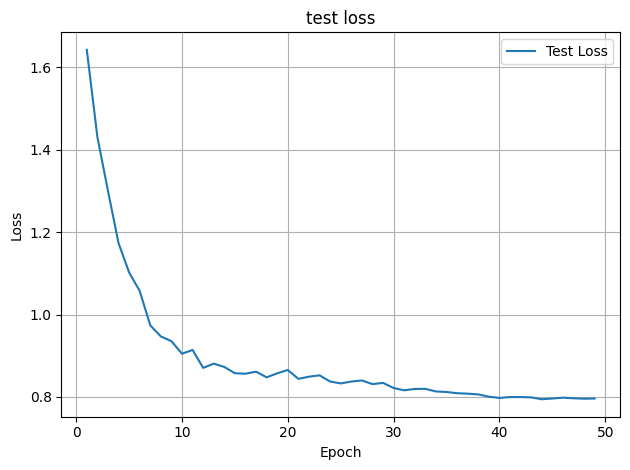

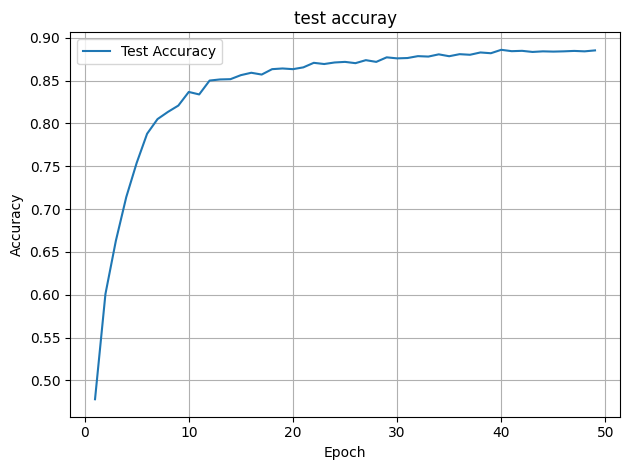

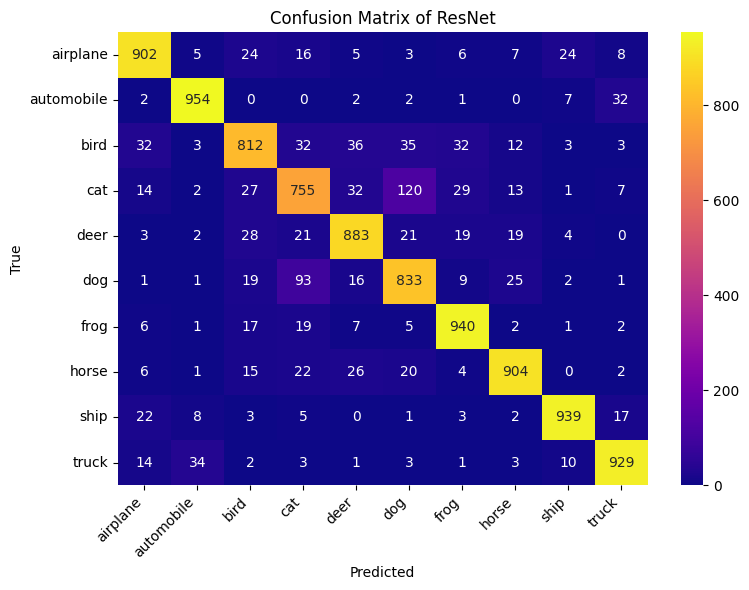

In [29]:
model = ResNet18(num_classes=10)
train(model, X_train, Y_train, X_test=X_test, Y_test=Y_test, epochs=50, batch=64, lr=0.1, reg_lambda=1e-3)